In [35]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torchvision.ops import Conv2dNormActivation

from dataclasses import dataclass
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sn

import matplotlib.pyplot as plt
import time
import numpy as np
import random
import warnings
import os
from tqdm import tqdm

import pandas as pd

from zipfile import ZipFile
from urllib.request import urlretrieve


%matplotlib inline
warnings.filterwarnings("ignore")

In [36]:
#set seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

set_seed(42)

In [37]:
#download and extract dataset
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assets....", end="")

    #download zip file
    urlretrieve(url, save_path)

    try:
        #extract
        with ZipFile(save_path) as z:
            #extract zipfile in same directory
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

URL = r"https://www.dropbox.com/s/45jdd8padeyjq6t/10_Monkey_Species.zip?dl=1"

dataset_path = os.path.join(os.getcwd(), "10_Monkey_Species.zip")

#download if asset ZIP doesn't exists
if not os.path.exists(dataset_path):
    download_and_unzip(URL, dataset_path)
else:
    print("Download already...")

Download already...


In [38]:
#set dataset and training config parameters

@dataclass(frozen=True)
class TrainingConfig:
    
    batch_size: int = 32
    num_epochs: int = 20
    learning_rate: float = 1e-4

    log_interval: int = 1
    test_interval: int = 1
    data_root: int = "./"
    num_workers: int = 5
    device: str = "cuda"

train_config = TrainingConfig()
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print("Devics:", DEVICE)

Devics: cuda


In [39]:
#process monkey file
train_root = os.path.join("10_Monkey_Species", "training", "training")
val_root = os.path.join("10_Monkey_Species", "validation", "validation")

In [40]:
#make pandas dataframe to arrange the data

df = pd.read_csv(os.path.join("10_Monkey_Species", "monkey_labels.txt"), sep=",", header=None)
df.columns = ["Labels", "Latin Name", "Common Name", "Train Images", "Validation Images"]
df["Latin Name"] = df["Latin Name"].str.replace("\t", " ")
df[1:]
                                                

,Labels,Latin Name,Common Name,Train Images,Validation Images
1,n0,alouatta_palliata,mantled_howler,131,26
2,n1,erythrocebus_patas,patas_monkey,139,28
3,n2,cacajao_calvus,bald_uakari,137,27
4,n3,macaca_fuscata,japanese_macaque,152,30
5,n4,cebuella_pygmea,pygmy_marmoset,131,26
6,n5,cebus_capucinus,white_headed_capuchin,141,28
7,n6,mico_argentatus,silvery_marmoset,132,26
8,n7,saimiri_sciureus,common_squirrel_monkey,142,28
9,n8,aotus_nigriceps,black_headed_night_monkey,133,27
10,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [41]:
#preprocessing
#normalise image data to range [0,1] with meaan and std od datasets



img_size = (224, 224)

preprocess = transforms.Compose(
    [
        transforms.Resize(img_size, antialias=True),
        transforms.ToTensor()
    ]
)

In [42]:
#find mean and std of dataset
def get_mean_std(train_loader, img_size=(224,224), num_workers=2):

    batch_mean = torch.zeros(3)
    batch_mean_sqrd  = torch.zeros(3)

    for batch_data, _ in train_loader:
        batch_mean += batch_data.mean(dim=(0, 2, 3)) #E[batch_i] #dim=1 is channel dim
        batch_mean_sqrd += (batch_data**2).mean(dim=(0, 2, 3)) #E[batch_i**2]

    mean = batch_mean / len(train_loader)

    var = (batch_mean_sqrd / len(train_loader)) - (mean**2)

    std = var**0.5
    print("mean: {}, std: {}".format(mean, std))

    return mean, std

train_data_mean_calc = datasets.ImageFolder(root=train_root, transform=preprocess)
train_loader_mean_calc = DataLoader(train_data_mean_calc, shuffle = True, batch_size = train_config.batch_size, num_workers = train_config.num_workers)
mean, std = get_mean_std(train_loader_mean_calc)

print("Mean of Dataset: ", mean)
print("Std of Dataset: ", std)

mean: tensor([0.4363, 0.4333, 0.3292]), std: tensor([0.2465, 0.2422, 0.2454])
Mean of Dataset:  tensor([0.4363, 0.4333, 0.3292])
Std of Dataset:  tensor([0.2465, 0.2422, 0.2454])


In [43]:
mean = [0.4368, 0.4336, 0.3294]
std = [0.2457, 0.2413, 0.2447]

common_transforms = transforms.Compose(
    [
        preprocess,
        transforms.Normalize(mean=mean, std=std)
    ]
)

train_transforms = transforms.Compose(
    [
        preprocess,
        transforms.RandomHorizontalFlip(),
        transforms.RandomErasing(p=0.4),
        transforms.RandomApply(
            [
                transforms.RandomAffine(degrees=(30,70), translate=(0.1, 0.3), scale=(0.5, 0.75))
            ], p=0.1),
        transforms.Normalize(mean=mean, std=std)
    ]
)

In [44]:
#dataloader preparation
#apply augmentation to train data
train_data = datasets.ImageFolder(root = train_root, transform = train_transforms)

#validation set
val_data = datasets.ImageFolder(root = val_root, transform = common_transforms)
train_data.classes


['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [45]:
train_data.class_to_idx


{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

In [46]:
len(train_data)

1097

In [47]:
train_loader = DataLoader(
    train_data,
    shuffle = True,
    batch_size = train_config.batch_size,
    num_workers = train_config.num_workers
)

val_loader = DataLoader(
    val_data,
    shuffle = False,
    batch_size = train_config.batch_size,
    num_workers = train_config.num_workers
)

In [48]:
len(next(iter(train_loader)))

2

In [49]:
class_mapping = {

    0: "mantled_howler",
    1: "patas_monkey",
    2: "bald_uakari",
    3: "japanese_macaque",
    4: "pygmy_marmoset",
    5: "white_headed_capuchin",
    6: "silvery_marmoset",
    7: "common_squirrel_monkey",
    8: "black_headed_night_monkey",
    9: "nilgiri_langur"
}

torch.Size([32, 3, 224, 224])


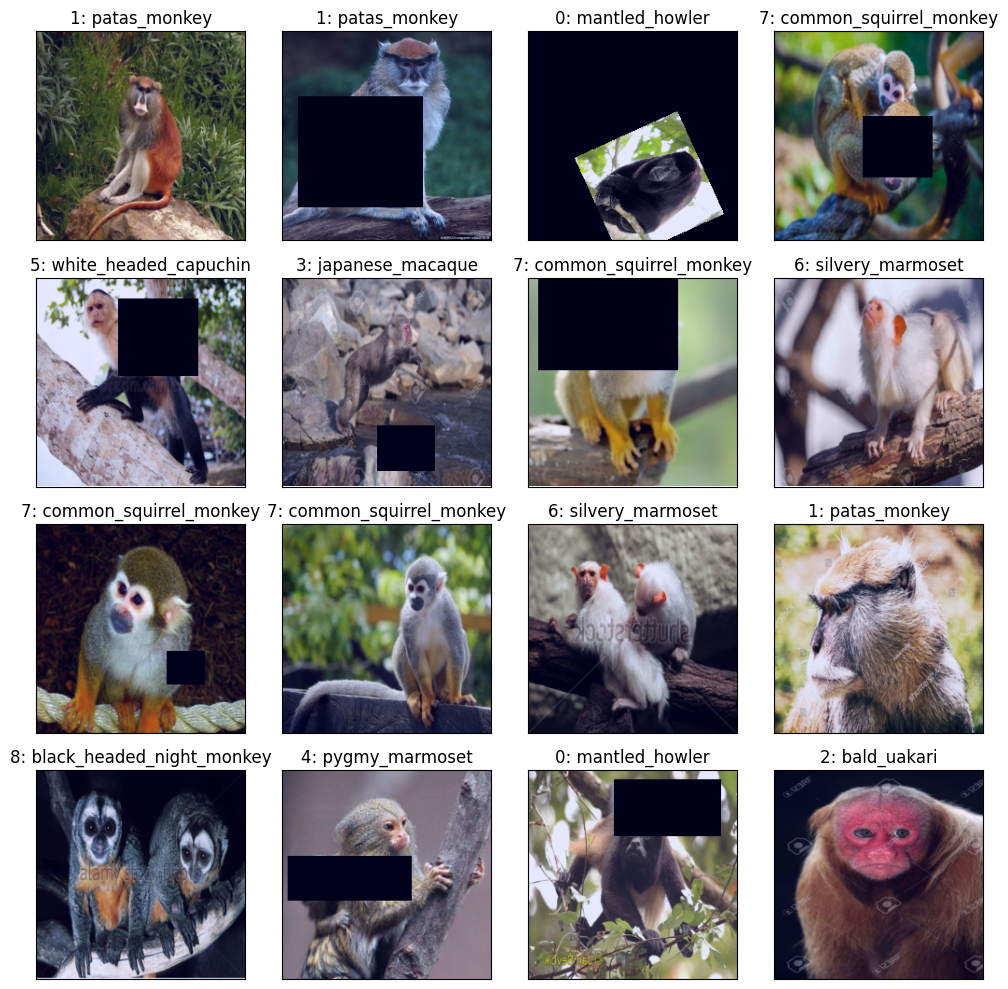

In [50]:
#display image
def visualize_images(dataloader, num_images = 20):
    fig = plt.figure(figsize=(10,10))

    #iterate over first batch
    images, labels = next(iter(dataloader))
    print(images.shape)

    num_rows = 4
    num_cols = int(np.ceil((num_images / num_rows)))

    for idx in range(min(num_images, len(images))):
        image, label = images[idx], labels[idx]

        ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks = [], yticks = [])

        image = image.permute(1,2,0) #matplotlib format

        #normalize image
        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image, cmap="gray") #remove batch dimension
        ax.set_title(f"{label.item()}: {class_mapping[label.item()]}")

    fig.tight_layout()
    plt.show()

visualize_images(train_loader, num_images = 16)

In [51]:
#model
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()

        self._model = nn.Sequential(

            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),

            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2),

            nn.LazyConv2d(out_channels = 64, kernel_size = 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),

            nn.LazyConv2d(out_channels = 128, kernel_size = 3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2),

            Conv2dNormActivation(in_channels = 128, out_channels = 256, kernel_size = 3), #apply conv2d -> batchnorm2d -> relu

            Conv2dNormActivation(in_channels = 256, out_channels = 256, kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2),

            Conv2dNormActivation(in_channels = 256, out_channels = 512, kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2),

            nn.AdaptiveAvgPool2d(output_size=(3,3)), #in_channels = out_channels
            nn.Flatten(),
            nn.Linear(in_features = 512*3*3, out_features = 256),
            nn.Linear(in_features = 256, out_features = 10)
        )

    def forward(self, x):
        return self._model(x)


In [52]:
model = MyModel()

optimizer = Adam(model.parameters(), lr = train_config.learning_rate)
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"

logdir = "runs/80epochs-3.3M_param_dropout"

writer = SummaryWriter(logdir)

dummy_input = (1, 3, 224, 224)
print(summary(model, dummy_input, row_settings = ["var_names"], device = "cpu"))


Layer (type (var_name))                  Output Shape              Param #
MyModel (MyModel)                        [1, 10]                   --
├─Sequential (_model)                    [1, 10]                   --
│    └─Conv2d (0)                        [1, 32, 220, 220]         2,432
│    └─BatchNorm2d (1)                   [1, 32, 220, 220]         64
│    └─ReLU (2)                          [1, 32, 220, 220]         --
│    └─Conv2d (3)                        [1, 32, 218, 218]         9,248
│    └─BatchNorm2d (4)                   [1, 32, 218, 218]         64
│    └─ReLU (5)                          [1, 32, 218, 218]         --
│    └─MaxPool2d (6)                     [1, 32, 109, 109]         --
│    └─Conv2d (7)                        [1, 64, 107, 107]         18,496
│    └─BatchNorm2d (8)                   [1, 64, 107, 107]         128
│    └─ReLU (9)                          [1, 64, 107, 107]         --
│    └─Conv2d (10)                       [1, 128, 105, 105]        73,856


In [53]:
#model training 
def train(model, train_loader):
    model.train()
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_train_samples = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_train_samples += labels.shape[0]
        correct_predictions += (predicted == labels).sum().item()

    train_avg_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_predictions / total_train_samples
    return train_avg_loss, train_accuracy

In [54]:
#model evaluation
def validation(model, val_loader):
    model.eval()
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_val_samples = 0

    for images, labels in tqdm(val_loader, desc="Validation"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(images)

        loss = F.cross_entropy(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_val_samples += labels.shape[0]
        correct_predictions += (predicted == labels).sum().item()

    val_avg_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct_predictions / total_val_samples

    return val_avg_loss, val_accuracy

In [55]:
#main function
def main(model, train_loader, val_loader):

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_acc = 0.0
    best_weights = None

    for epoch in range(train_config.num_epochs):
        train_loss, train_accuracy = train(model, train_loader)
        val_loss, val_accuracy = validation(model, val_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1:0>2}/{train_config.num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # log to tensorboard
        writer.add_scalar('Loss/train', train_loss)
        writer.add_scalar('Loss/val', val_loss)
        writer.add_scalar('Accuracy/train', train_accuracy)
        writer.add_scalar('Accuracy/val', val_accuracy)

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_weights = model.state_dict()
            print(f"Saving best model....")
            torch.save(best_weights, "monkey_best.pt")

    return train_losses, train_accuracies, val_losses, val_accuracies
    

In [56]:
train_losses, train_accuracies, val_losses, val_accuracies = main(model, train_loader, val_loader)

Validation: 100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


Epoch 01/20 - Train Loss: 1.9613, Train Accuracy: 31.54% - Val Loss: 1.9279, Val Accuracy: 30.15%
Saving best model....


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 02/20 - Train Loss: 1.4555, Train Accuracy: 49.68% - Val Loss: 1.3723, Val Accuracy: 51.47%
Saving best model....


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]


Epoch 03/20 - Train Loss: 1.2564, Train Accuracy: 55.70% - Val Loss: 1.4616, Val Accuracy: 52.21%
Saving best model....


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 04/20 - Train Loss: 1.1641, Train Accuracy: 58.89% - Val Loss: 1.1303, Val Accuracy: 60.29%
Saving best model....


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]


Epoch 05/20 - Train Loss: 1.0863, Train Accuracy: 62.08% - Val Loss: 1.0994, Val Accuracy: 63.24%
Saving best model....


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]


Epoch 06/20 - Train Loss: 1.0088, Train Accuracy: 65.91% - Val Loss: 0.9555, Val Accuracy: 65.44%
Saving best model....


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


Epoch 07/20 - Train Loss: 0.9140, Train Accuracy: 70.83% - Val Loss: 0.9598, Val Accuracy: 66.91%
Saving best model....


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]


Epoch 08/20 - Train Loss: 0.8935, Train Accuracy: 69.74% - Val Loss: 0.9509, Val Accuracy: 70.22%
Saving best model....


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]


Epoch 09/20 - Train Loss: 0.7682, Train Accuracy: 74.93% - Val Loss: 0.8771, Val Accuracy: 69.85%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


Epoch 10/20 - Train Loss: 0.8203, Train Accuracy: 71.74% - Val Loss: 0.9343, Val Accuracy: 70.96%
Saving best model....


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 11/20 - Train Loss: 0.7793, Train Accuracy: 72.20% - Val Loss: 0.8822, Val Accuracy: 71.69%
Saving best model....


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


Epoch 12/20 - Train Loss: 0.7272, Train Accuracy: 72.29% - Val Loss: 0.8227, Val Accuracy: 70.96%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Epoch 13/20 - Train Loss: 0.7004, Train Accuracy: 76.94% - Val Loss: 0.9037, Val Accuracy: 72.43%
Saving best model....


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


Epoch 14/20 - Train Loss: 0.6565, Train Accuracy: 79.12% - Val Loss: 0.7441, Val Accuracy: 76.84%
Saving best model....


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 15/20 - Train Loss: 0.6180, Train Accuracy: 78.85% - Val Loss: 0.7927, Val Accuracy: 76.84%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]


Epoch 16/20 - Train Loss: 0.5866, Train Accuracy: 79.85% - Val Loss: 0.8013, Val Accuracy: 75.00%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Epoch 17/20 - Train Loss: 0.6034, Train Accuracy: 79.12% - Val Loss: 0.8326, Val Accuracy: 77.21%
Saving best model....


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


Epoch 18/20 - Train Loss: 0.4958, Train Accuracy: 82.77% - Val Loss: 0.8634, Val Accuracy: 72.43%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]


Epoch 19/20 - Train Loss: 0.5716, Train Accuracy: 81.04% - Val Loss: 0.6630, Val Accuracy: 77.21%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]

Epoch 20/20 - Train Loss: 0.5206, Train Accuracy: 82.50% - Val Loss: 0.7279, Val Accuracy: 75.74%


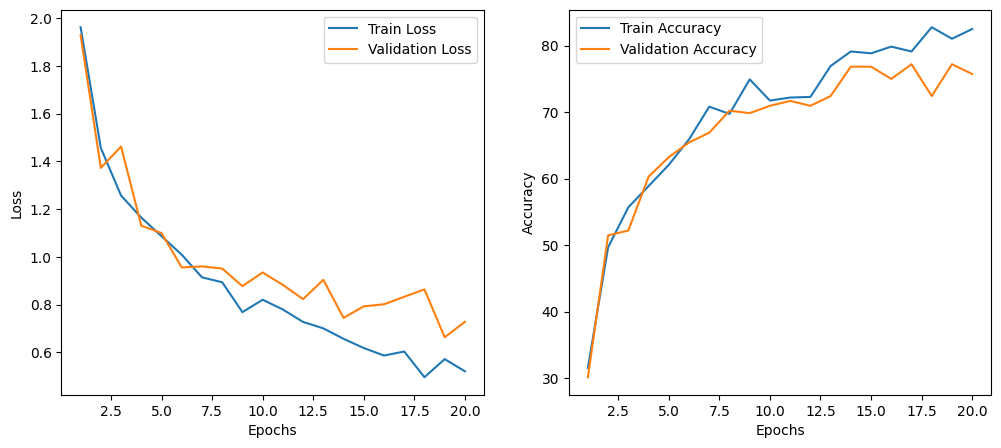

In [57]:
#plot graph
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,train_config.num_epochs + 1), train_losses, label = "Train Loss")
plt.plot(range(1, train_config.num_epochs + 1), val_losses, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, train_config.num_epochs + 1), train_accuracies, label = "Train Accuracy")
plt.plot(range(1, train_config.num_epochs + 1), val_accuracies, label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [77]:
#load best model
model.load_state_dict(torch.load("monkey_best.pt"))
model.eval()

RuntimeError: Error(s) in loading state_dict for MyModel:
	Missing key(s) in state_dict: "_model.0.weight", "_model.0.bias", "_model.1.weight", "_model.1.bias", "_model.1.running_mean", "_model.1.running_var", "_model.3.weight", "_model.3.bias", "_model.4.weight", "_model.4.bias", "_model.4.running_mean", "_model.4.running_var", "_model.7.weight", "_model.7.bias", "_model.8.weight", "_model.8.bias", "_model.8.running_mean", "_model.8.running_var", "_model.10.weight", "_model.10.bias", "_model.11.weight", "_model.11.bias", "_model.11.running_mean", "_model.11.running_var", "_model.14.0.weight", "_model.14.1.weight", "_model.14.1.bias", "_model.14.1.running_mean", "_model.14.1.running_var", "_model.15.0.weight", "_model.15.1.weight", "_model.15.1.bias", "_model.15.1.running_mean", "_model.15.1.running_var", "_model.17.0.weight", "_model.17.1.weight", "_model.17.1.bias", "_model.17.1.running_mean", "_model.17.1.running_var", "_model.21.weight", "_model.21.bias", "_model.22.weight", "_model.22.bias". 
	Unexpected key(s) in state_dict: "features.0.0.weight", "features.0.1.weight", "features.0.1.bias", "features.0.1.running_mean", "features.0.1.running_var", "features.0.1.num_batches_tracked", "features.1.block.0.0.weight", "features.1.block.0.1.weight", "features.1.block.0.1.bias", "features.1.block.0.1.running_mean", "features.1.block.0.1.running_var", "features.1.block.0.1.num_batches_tracked", "features.1.block.1.fc1.weight", "features.1.block.1.fc1.bias", "features.1.block.1.fc2.weight", "features.1.block.1.fc2.bias", "features.1.block.2.0.weight", "features.1.block.2.1.weight", "features.1.block.2.1.bias", "features.1.block.2.1.running_mean", "features.1.block.2.1.running_var", "features.1.block.2.1.num_batches_tracked", "features.2.block.0.0.weight", "features.2.block.0.1.weight", "features.2.block.0.1.bias", "features.2.block.0.1.running_mean", "features.2.block.0.1.running_var", "features.2.block.0.1.num_batches_tracked", "features.2.block.1.0.weight", "features.2.block.1.1.weight", "features.2.block.1.1.bias", "features.2.block.1.1.running_mean", "features.2.block.1.1.running_var", "features.2.block.1.1.num_batches_tracked", "features.2.block.2.0.weight", "features.2.block.2.1.weight", "features.2.block.2.1.bias", "features.2.block.2.1.running_mean", "features.2.block.2.1.running_var", "features.2.block.2.1.num_batches_tracked", "features.3.block.0.0.weight", "features.3.block.0.1.weight", "features.3.block.0.1.bias", "features.3.block.0.1.running_mean", "features.3.block.0.1.running_var", "features.3.block.0.1.num_batches_tracked", "features.3.block.1.0.weight", "features.3.block.1.1.weight", "features.3.block.1.1.bias", "features.3.block.1.1.running_mean", "features.3.block.1.1.running_var", "features.3.block.1.1.num_batches_tracked", "features.3.block.2.0.weight", "features.3.block.2.1.weight", "features.3.block.2.1.bias", "features.3.block.2.1.running_mean", "features.3.block.2.1.running_var", "features.3.block.2.1.num_batches_tracked", "features.4.block.0.0.weight", "features.4.block.0.1.weight", "features.4.block.0.1.bias", "features.4.block.0.1.running_mean", "features.4.block.0.1.running_var", "features.4.block.0.1.num_batches_tracked", "features.4.block.1.0.weight", "features.4.block.1.1.weight", "features.4.block.1.1.bias", "features.4.block.1.1.running_mean", "features.4.block.1.1.running_var", "features.4.block.1.1.num_batches_tracked", "features.4.block.2.fc1.weight", "features.4.block.2.fc1.bias", "features.4.block.2.fc2.weight", "features.4.block.2.fc2.bias", "features.4.block.3.0.weight", "features.4.block.3.1.weight", "features.4.block.3.1.bias", "features.4.block.3.1.running_mean", "features.4.block.3.1.running_var", "features.4.block.3.1.num_batches_tracked", "features.5.block.0.0.weight", "features.5.block.0.1.weight", "features.5.block.0.1.bias", "features.5.block.0.1.running_mean", "features.5.block.0.1.running_var", "features.5.block.0.1.num_batches_tracked", "features.5.block.1.0.weight", "features.5.block.1.1.weight", "features.5.block.1.1.bias", "features.5.block.1.1.running_mean", "features.5.block.1.1.running_var", "features.5.block.1.1.num_batches_tracked", "features.5.block.2.fc1.weight", "features.5.block.2.fc1.bias", "features.5.block.2.fc2.weight", "features.5.block.2.fc2.bias", "features.5.block.3.0.weight", "features.5.block.3.1.weight", "features.5.block.3.1.bias", "features.5.block.3.1.running_mean", "features.5.block.3.1.running_var", "features.5.block.3.1.num_batches_tracked", "features.6.block.0.0.weight", "features.6.block.0.1.weight", "features.6.block.0.1.bias", "features.6.block.0.1.running_mean", "features.6.block.0.1.running_var", "features.6.block.0.1.num_batches_tracked", "features.6.block.1.0.weight", "features.6.block.1.1.weight", "features.6.block.1.1.bias", "features.6.block.1.1.running_mean", "features.6.block.1.1.running_var", "features.6.block.1.1.num_batches_tracked", "features.6.block.2.fc1.weight", "features.6.block.2.fc1.bias", "features.6.block.2.fc2.weight", "features.6.block.2.fc2.bias", "features.6.block.3.0.weight", "features.6.block.3.1.weight", "features.6.block.3.1.bias", "features.6.block.3.1.running_mean", "features.6.block.3.1.running_var", "features.6.block.3.1.num_batches_tracked", "features.7.block.0.0.weight", "features.7.block.0.1.weight", "features.7.block.0.1.bias", "features.7.block.0.1.running_mean", "features.7.block.0.1.running_var", "features.7.block.0.1.num_batches_tracked", "features.7.block.1.0.weight", "features.7.block.1.1.weight", "features.7.block.1.1.bias", "features.7.block.1.1.running_mean", "features.7.block.1.1.running_var", "features.7.block.1.1.num_batches_tracked", "features.7.block.2.fc1.weight", "features.7.block.2.fc1.bias", "features.7.block.2.fc2.weight", "features.7.block.2.fc2.bias", "features.7.block.3.0.weight", "features.7.block.3.1.weight", "features.7.block.3.1.bias", "features.7.block.3.1.running_mean", "features.7.block.3.1.running_var", "features.7.block.3.1.num_batches_tracked", "features.8.block.0.0.weight", "features.8.block.0.1.weight", "features.8.block.0.1.bias", "features.8.block.0.1.running_mean", "features.8.block.0.1.running_var", "features.8.block.0.1.num_batches_tracked", "features.8.block.1.0.weight", "features.8.block.1.1.weight", "features.8.block.1.1.bias", "features.8.block.1.1.running_mean", "features.8.block.1.1.running_var", "features.8.block.1.1.num_batches_tracked", "features.8.block.2.fc1.weight", "features.8.block.2.fc1.bias", "features.8.block.2.fc2.weight", "features.8.block.2.fc2.bias", "features.8.block.3.0.weight", "features.8.block.3.1.weight", "features.8.block.3.1.bias", "features.8.block.3.1.running_mean", "features.8.block.3.1.running_var", "features.8.block.3.1.num_batches_tracked", "features.9.block.0.0.weight", "features.9.block.0.1.weight", "features.9.block.0.1.bias", "features.9.block.0.1.running_mean", "features.9.block.0.1.running_var", "features.9.block.0.1.num_batches_tracked", "features.9.block.1.0.weight", "features.9.block.1.1.weight", "features.9.block.1.1.bias", "features.9.block.1.1.running_mean", "features.9.block.1.1.running_var", "features.9.block.1.1.num_batches_tracked", "features.9.block.2.fc1.weight", "features.9.block.2.fc1.bias", "features.9.block.2.fc2.weight", "features.9.block.2.fc2.bias", "features.9.block.3.0.weight", "features.9.block.3.1.weight", "features.9.block.3.1.bias", "features.9.block.3.1.running_mean", "features.9.block.3.1.running_var", "features.9.block.3.1.num_batches_tracked", "features.10.block.0.0.weight", "features.10.block.0.1.weight", "features.10.block.0.1.bias", "features.10.block.0.1.running_mean", "features.10.block.0.1.running_var", "features.10.block.0.1.num_batches_tracked", "features.10.block.1.0.weight", "features.10.block.1.1.weight", "features.10.block.1.1.bias", "features.10.block.1.1.running_mean", "features.10.block.1.1.running_var", "features.10.block.1.1.num_batches_tracked", "features.10.block.2.fc1.weight", "features.10.block.2.fc1.bias", "features.10.block.2.fc2.weight", "features.10.block.2.fc2.bias", "features.10.block.3.0.weight", "features.10.block.3.1.weight", "features.10.block.3.1.bias", "features.10.block.3.1.running_mean", "features.10.block.3.1.running_var", "features.10.block.3.1.num_batches_tracked", "features.11.block.0.0.weight", "features.11.block.0.1.weight", "features.11.block.0.1.bias", "features.11.block.0.1.running_mean", "features.11.block.0.1.running_var", "features.11.block.0.1.num_batches_tracked", "features.11.block.1.0.weight", "features.11.block.1.1.weight", "features.11.block.1.1.bias", "features.11.block.1.1.running_mean", "features.11.block.1.1.running_var", "features.11.block.1.1.num_batches_tracked", "features.11.block.2.fc1.weight", "features.11.block.2.fc1.bias", "features.11.block.2.fc2.weight", "features.11.block.2.fc2.bias", "features.11.block.3.0.weight", "features.11.block.3.1.weight", "features.11.block.3.1.bias", "features.11.block.3.1.running_mean", "features.11.block.3.1.running_var", "features.11.block.3.1.num_batches_tracked", "features.12.0.weight", "features.12.1.weight", "features.12.1.bias", "features.12.1.running_mean", "features.12.1.running_var", "features.12.1.num_batches_tracked", "classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias". 

In [59]:
def prediction(model, val_loader):

    model.eval()
    model.to(DEVICE)

    all_images, all_labels = [], []
    all_pred_indices, all_pred_probs = [], []

    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.inference_mode():
            outputs = model(images)

        prob = F.softmax(outputs, dim=1)
        pred_indices = prob.data.max(dim=1)[1]
        pred_probs = prob.data.max(dim=1)[0]

        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_pred_indices.append(pred_indices.cpu())
        all_pred_probs.append(pred_probs.cpu())

    return (torch.cat(all_images).numpy(),
            torch.cat(all_labels).numpy(),
            torch.cat(all_pred_indices).numpy(),
            torch.cat(all_pred_probs).numpy())


def denormalize(image): #denormalize and make pixel value to (0, 1)
    mean_ar = np.array(mean)
    std_ar = np.array(std)
    image = image * std_ar + mean_ar
    return np.clip(image, 0, 1)

In [60]:
def visualise_predictions(sample_images, sample_gt_labels, pred_indices, pred_probs, num_images = 5):

    fig = plt.figure(figsize = (20, 5))

    for i in range(num_images):
        idx = random.randint(0, len(sample_images - 1))
        image = sample_images[idx].transpose(1, 2, 0) #c,h,w -> h,w,c
        label = sample_gt_labels[idx]
        pred_idx = pred_indices[idx]
        pred_prob = pred_probs[idx]

        image = denormalize(image)

        ax = fig.add_subplot(1, num_images, i+1)
        ax.imshow(image)
        ax.set_title(f"GT: {class_mapping[label]}\nPred: {class_mapping[pred_idx]} ({pred_prob:.2f})")
        ax.axis('off')

    plt.show()



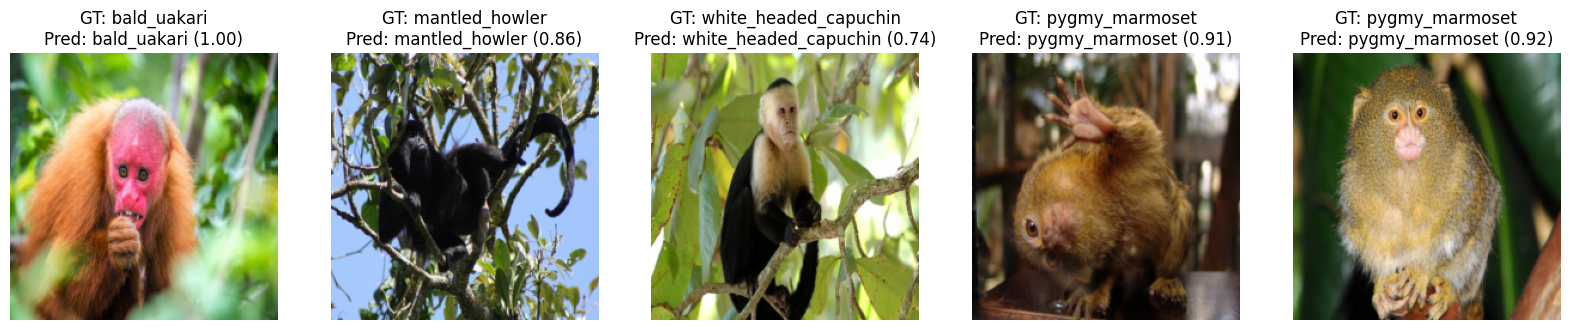

In [61]:
val_images, val_gt_labels, pred_indices, pred_probs = prediction(model, val_loader)
visualise_predictions(val_images, val_gt_labels, pred_indices, pred_probs, num_images = 5)

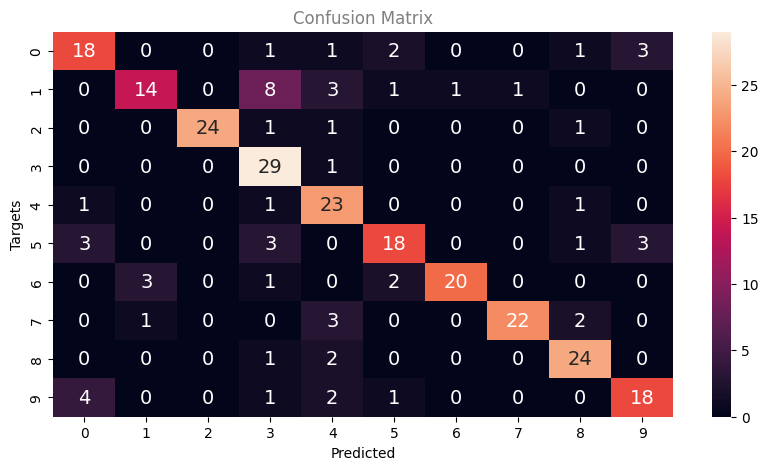

In [62]:
#confusion matrix
cm = confusion_matrix(y_true=val_gt_labels, y_pred = pred_indices)

plt.figure(figsize=[10,5])
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size":14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title(f"Confusion Matrix", color="gray")
plt.show()

In [68]:
#finetune a pretrained model
from torchvision.models import mobilenet_v3_small

#load model (mobilenet)
mobilenetv3_model = mobilenet_v3_small(weights="DEFAULT")

#feature layers
num_feature_layers = len(mobilenetv3_model.features)
print(f"Number of feature layers: {num_feature_layers}")

#classifier layer
num_classifier_layers = len(mobilenetv3_model.classifier)
print(f"Number of classifier layers: {num_classifier_layers}")

Number of feature layers: 13
Number of classifier layers: 4


In [69]:
#set require_grad to true for all parameter
#freeze earlier 10 layers 
for param in mobilenetv3_model.features[:10].parameters():
    param.requires_grad = False

print(mobilenetv3_model.classifier[3]) #check final layer



Linear(in_features=1024, out_features=1000, bias=True)


In [70]:
#replace final layer of classifier to match no of class in dataset
mobilenetv3_model.classifier[3] = nn.Linear(in_features = 1024, out_features = 10, bias = True)
m_model = mobilenetv3_model

#store tensorboard
logdir = "runs/mobilenetv3-Monkey-Species-finetune"

writer = SummaryWriter(logdir)

summary(m_model, input_size=(1, 3, 224, 224), row_settings=["var_names"], device="cpu")




Layer (type (var_name))                                      Output Shape              Param #
MobileNetV3 (MobileNetV3)                                    [1, 10]                   --
├─Sequential (features)                                      [1, 576, 7, 7]            --
│    └─Conv2dNormActivation (0)                              [1, 16, 112, 112]         --
│    │    └─Conv2d (0)                                       [1, 16, 112, 112]         (432)
│    │    └─BatchNorm2d (1)                                  [1, 16, 112, 112]         (32)
│    │    └─Hardswish (2)                                    [1, 16, 112, 112]         --
│    └─InvertedResidual (1)                                  [1, 16, 56, 56]           --
│    │    └─Sequential (block)                               [1, 16, 56, 56]           (744)
│    └─InvertedResidual (2)                                  [1, 24, 28, 28]           --
│    │    └─Sequential (block)                               [1, 24, 28, 28]           

In [71]:
train_losses, train_accuracies, val_losses, val_accuracies = main(m_model, train_loader, val_loader)

Validation: 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]


Epoch 01/20 - Train Loss: 2.3700, Train Accuracy: 8.02% - Val Loss: 2.3930, Val Accuracy: 10.66%
Saving best model....


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]


Epoch 02/20 - Train Loss: 2.3641, Train Accuracy: 9.02% - Val Loss: 2.3857, Val Accuracy: 11.03%
Saving best model....


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


Epoch 03/20 - Train Loss: 2.3703, Train Accuracy: 8.39% - Val Loss: 2.3805, Val Accuracy: 11.03%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 04/20 - Train Loss: 2.3750, Train Accuracy: 9.75% - Val Loss: 2.3760, Val Accuracy: 9.19%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 05/20 - Train Loss: 2.3653, Train Accuracy: 8.30% - Val Loss: 2.3725, Val Accuracy: 8.09%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.52it/s]


Epoch 06/20 - Train Loss: 2.3642, Train Accuracy: 8.20% - Val Loss: 2.3704, Val Accuracy: 6.99%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]


Epoch 07/20 - Train Loss: 2.3697, Train Accuracy: 8.02% - Val Loss: 2.3686, Val Accuracy: 6.25%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 08/20 - Train Loss: 2.3611, Train Accuracy: 9.02% - Val Loss: 2.3672, Val Accuracy: 6.99%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]


Epoch 09/20 - Train Loss: 2.3648, Train Accuracy: 7.84% - Val Loss: 2.3668, Val Accuracy: 6.62%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 10/20 - Train Loss: 2.3657, Train Accuracy: 8.30% - Val Loss: 2.3666, Val Accuracy: 6.25%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]


Epoch 11/20 - Train Loss: 2.3560, Train Accuracy: 10.03% - Val Loss: 2.3661, Val Accuracy: 6.62%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]


Epoch 12/20 - Train Loss: 2.3675, Train Accuracy: 9.30% - Val Loss: 2.3661, Val Accuracy: 6.62%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


Epoch 13/20 - Train Loss: 2.3733, Train Accuracy: 9.02% - Val Loss: 2.3659, Val Accuracy: 7.35%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Epoch 14/20 - Train Loss: 2.3652, Train Accuracy: 8.20% - Val Loss: 2.3661, Val Accuracy: 7.35%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


Epoch 15/20 - Train Loss: 2.3731, Train Accuracy: 8.02% - Val Loss: 2.3658, Val Accuracy: 6.99%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Epoch 16/20 - Train Loss: 2.3709, Train Accuracy: 7.84% - Val Loss: 2.3660, Val Accuracy: 6.99%


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


Epoch 17/20 - Train Loss: 2.3656, Train Accuracy: 7.75% - Val Loss: 2.3657, Val Accuracy: 6.99%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


Epoch 18/20 - Train Loss: 2.3620, Train Accuracy: 8.57% - Val Loss: 2.3656, Val Accuracy: 6.62%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]


Epoch 19/20 - Train Loss: 2.3717, Train Accuracy: 8.11% - Val Loss: 2.3650, Val Accuracy: 6.62%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

Epoch 20/20 - Train Loss: 2.3748, Train Accuracy: 8.02% - Val Loss: 2.3646, Val Accuracy: 6.62%


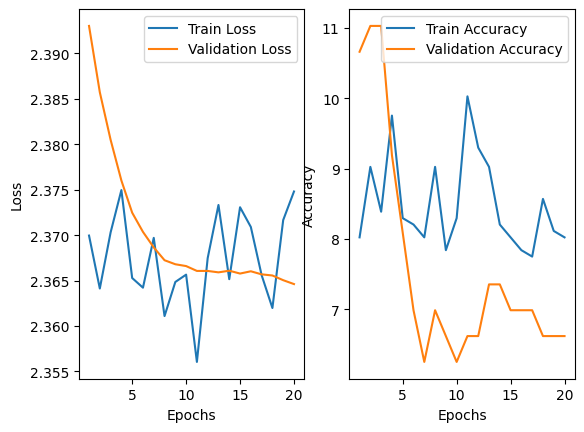

In [72]:
#visualise preformance
plt.subplot(1, 2, 1)  
plt.plot(range(1, train_config.num_epochs + 1), train_losses, label="Train Loss")  
plt.plot(range(1, train_config.num_epochs + 1), val_losses, label="Validation Loss")  
plt.xlabel("Epochs")  
plt.ylabel("Loss")  
plt.legend()  


plt.subplot(1, 2, 2)  
plt.plot(range(1, train_config.num_epochs + 1), train_accuracies, label="Train Accuracy")  
plt.plot(range(1, train_config.num_epochs + 1), val_accuracies, label="Validation Accuracy")  
plt.xlabel("Epochs")  
plt.ylabel("Accuracy")  
plt.legend()  

plt.show() 

In [74]:
m_model.load_state_dict(torch.load("monkey_best.pt"))
m_model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

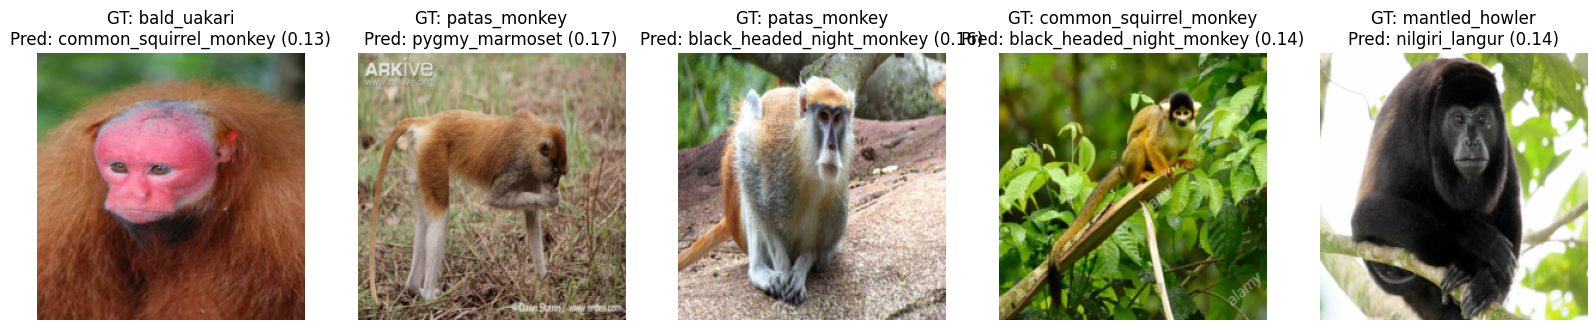

In [75]:
#test on validation
val_images, val_gt_labels, pred_indices, pred_probs = prediction(m_model, val_loader)

visualise_predictions(val_images, val_gt_labels, pred_indices, pred_probs, num_images=5)

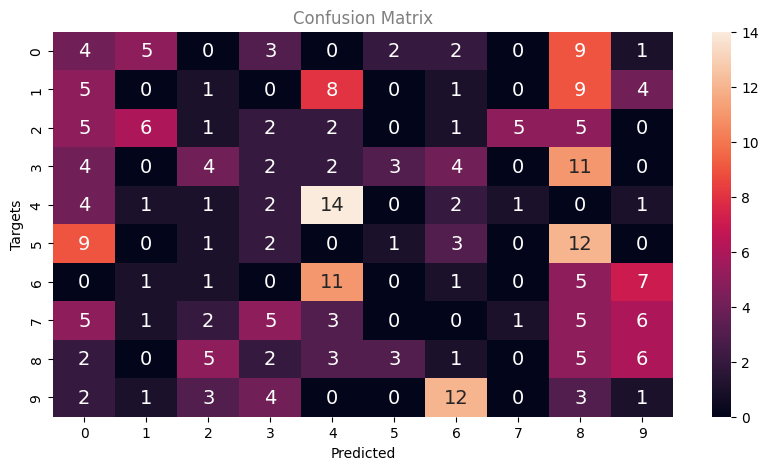

In [76]:
#confusion matrix
cm = confusion_matrix(y_true=val_gt_labels, y_pred=pred_indices)

plt.figure(figsize=[10, 5])

sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})  # Display numerical values in the heatmap

plt.xlabel("Predicted")  
plt.ylabel("Targets")  

plt.title(f"Confusion Matrix", color="gray")

plt.show()